In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from konlpy.tag import Mecab
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostRegressor, Pool

## 첫 번째

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### 띄어쓰기 및 오타 수정

In [6]:
train.at[1142, '중식메뉴'] = '쌀밥/곤드레밥/찰현미밥 된장찌개 돼지고추장불고기 버섯잡채 삼색물만두무침 겉절이김치/양념장 견과류샐러드*요거트D'

train['중식메뉴'] = train['중식메뉴'].str.replace('삽겹', '삼겹')

***

In [7]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['요일'] = train['일자'].dt.day_name().str[:2].map({'Mo' : 5, 'Tu' : 4, 'We' : 3, 'Th' : 2, 'Fr' : 1})
test['요일'] = test['일자'].dt.day_name().str[:2].map({'Mo' : 5, 'Tu' : 4, 'We' : 3, 'Th' : 2, 'Fr' : 1})

train['month'] = train['일자'].dt.month
test['month'] = test['일자'].dt.month

train['corona'] = [1 if x > 0 else 0 for x in train['현본사소속재택근무자수']]
test['corona'] = [1 if x > 0 else 0 for x in test['현본사소속재택근무자수']]

#### 다음 출근날까지의 일수 차이
- ex) 오늘이 12월 31일 목요일인 경우 다음 출근날은 1월 4일이기 때문에 값이 4

In [8]:
train['shift_1day'] = train.일자.shift(-1)
test['shift_1day'] = test.일자.shift(-1)

train.at[1204, 'shift_1day'] = datetime(2021,1,27)
test.at[49, 'shift_1day'] = datetime(2021,4,12)

train['day_gap'] = (train.shift_1day - train.일자).astype(str)
test['day_gap'] = (test.shift_1day - test.일자).astype(str)

train.at[0, 'day_gap'] = '1 days'
test.at[0, 'day_gap'] = '1 days'

In [51]:
def get_holiday_score(x) :
    
    s = int(re.sub(r'[^0-9]', '', x))
    if s == 1 :
        return 0
    else :
        return 1

In [52]:
train['day_gap'] = train.day_gap.apply(get_holiday_score)
test['day_gap'] = test.day_gap.apply(get_holiday_score)

In [53]:
train['야근요일'] = train.요일.apply(lambda x : 1 if (x == 1) or (x == 3) else 0)
test['야근요일'] = test.요일.apply(lambda x : 1 if (x == 1) or (x == 3) else 0)

***

In [62]:
train['중식메뉴'] = train['중식메뉴'].str.split(' ')
train['석식메뉴'] = train['석식메뉴'].str.split(' ')

test['중식메뉴'] = test['중식메뉴'].str.split(' ')
test['석식메뉴'] = test['석식메뉴'].str.split(' ')

In [63]:
def get_token(data) :
    tokens = []
    for token in data :
        s_list = []
        for t in token :
            if t.startswith('(N') :
                s_list.append(t)
            elif (t.startswith('(') == False) & (len(t) > 1) :
                s_list.append(t)
            else :
                pass
        tokens.append(s_list)
    return tokens

In [64]:
train['중식_토큰'] = get_token(train['중식메뉴'])
train['석식_토큰'] = get_token(train['석식메뉴'])

In [65]:
test['중식_토큰'] = get_token(test['중식메뉴'])
test['석식_토큰'] = get_token(test['석식메뉴'])

In [67]:
train['중식메뉴수'] = train.중식_토큰.apply(len)
train['석식메뉴수'] = train.석식_토큰.apply(len)

test['중식메뉴수'] = test.중식_토큰.apply(len)
test['석식메뉴수'] = test.석식_토큰.apply(len)

### 식재료
- 중식에만 처리함 -> 메뉴가 중식에서 더 중요할 것으로 판단했기 때문

In [68]:
def get_ingredient(data) :
    
    ing_df = pd.DataFrame(np.zeros((data.shape[0], 7)), columns = ['해산물', '소', '돼지', '닭', '오리', '채소', '재료_기타'])

    for t in range(data.shape[0]) :
        token = data.중식_토큰.str[2][t]
        if '연어' in token or'골뱅이' in token or'열기' in token or'조기' in token or'탕수어' in token or'양장피' in token or'홍어' in token or'명태' in token or'적어' in token or'장어' in token or'동태' in token or'산슬' in token or'코다리' in token or'가자미' in token or'해물' in token or'생선' in token or'새우' in token or'꽁치' in token or'갈치' in token or'임연수' in token or'삼치' in token or'고등어' in token or'굴비' in token or'오징어' in token or'쭈꾸미' in token or'주꾸미' in token or'낙지' in token or'문어' in token :
            ing_df.at[t, '해산물'] = 1
        elif '왕갈비' in token or'소갈비' in token or'장조림' in token or'불고기' in token or'차돌' in token or'육전' in token or'너비아니' in token or'떡갈비' in token or(token.startswith('소') & (token.startswith('소세') == False)) or '함박' in token or'쇠고기' in token or'소고기' in token or'쇠' in token :
            ing_df.at[t, '소'] = 1
        elif '궁보계정' in token or'삼계탕' in token or'윙' in token or'유린기' in token or'깐풍'in token or'닭' in token or'치킨' in token or'후라이드' in token :
            ing_df.at[t, '돼지'] = 1
        elif '폭립' in token or'오향장육' in token or'동파육' in token or'히레카츠' in token or'순대' in token or'미트볼' in token or'등갈비' in token or'소세지' in token or'목살' in token or'탕수육' in token or'제육' in token or'돈' in token or'돼지' in token or'두루치기' in token or'삼겹' in token or'보쌈' in token or'족발' in token :
            ing_df.at[t, '닭'] = 1
        elif '오리' in token :
            ing_df.at[t, '오리'] = 1
        elif token.endswith('두부') or '꼬치산적' in token or '고추' in token or'양파' in token or'부추' in token or'고구마' in token or'감자' in token or'깻잎' in token or'샐러드' in token or'시금치' in token or'야채' in token :
            ing_df.at[t, '채소'] = 1
        else :
            ing_df.at[t, '재료_기타'] = 1
            
    return ing_df

In [69]:
train = pd.concat([train, get_ingredient(train)], axis = 1)
test = pd.concat([test, get_ingredient(test)], axis = 1)

### 조리법

In [70]:
def get_recipe(data, col) :
    tm = col[:2]
    cat = ['전', '무침','튀김', '찜', '볶음', '조림', '구이', '훈제', '조리_기타']
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 9)), columns = [f'{tm}_{x}' for x in cat])

    for t in range(data.shape[0]) :
        try :
            token = data[col][t]
            if '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token or token.endswith('볶음') or '볶음' in token :
                recipe_df.at[t, f'{tm}_볶음'] = 1 
            elif token.endswith('데리야끼') or token.endswith('립') or '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token :
                recipe_df.at[t, f'{tm}_구이'] = 1
            elif '전병' in token or token.endswith('전') :
                recipe_df.at[t, f'{tm}_전'] = 1
            elif token.endswith('김치말이') or token.endswith('만두') or '보쌈' in token or '수육' in token or token.endswith('찜') or '찜' in token :
                recipe_df.at[t, f'{tm}_찜'] = 1
            elif '파채' in token or token.endswith('무침') or token.endswith('샐러드') or '양장피' in token :
                recipe_df.at[t, f'{tm}_무침'] = 1
            elif '오향장육' in token or '동파육' in token or token.endswith('조림') :
                recipe_df.at[t, f'{tm}_조림'] = 1
            elif '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or '고로케' in token or '유린기' in token or '탕수' in token or token.endswith('닭') or token.endswith('치킨') or token.endswith('튀김') or '너겟' in token or token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token :
                recipe_df.at[t, f'{tm}_튀김'] = 1
            elif '훈제' in token :
                recipe_df.at[t, f'{tm}_훈제'] = 1
            else :
                recipe_df.at[t, f'{tm}_조리_기타'] = 1
        except :
            recipe_df.at[t, f'{tm}_조리_기타'] = 1
    return recipe_df

In [71]:
train['중식_메인요리'] = train.중식_토큰.str[2]
test['중식_메인요리'] = test.중식_토큰.str[2]

In [72]:
train['석식_메인요리'] = train.석식_토큰.str[2]
test['석식_메인요리'] = test.석식_토큰.str[2]

In [73]:
train = pd.concat([train, get_recipe(train, '중식_메인요리')], axis = 1)
test = pd.concat([test, get_recipe(test, '중식_메인요리')], axis = 1)

In [74]:
train = pd.concat([train, get_recipe(train, '석식_메인요리')], axis = 1)
test = pd.concat([test, get_recipe(test, '석식_메인요리')], axis = 1)

In [75]:
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

In [76]:
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [77]:
X1 = train[['요일', '야근요일', '출근', 'day_gap', '휴가비율', '출장비율', '야근비율', 'month',  '중식메뉴수', '해산물', '소', '돼지', '닭', '오리', '채소', '재료_기타', '중식_전', '중식_무침', '중식_튀김', '중식_찜', 
       '중식_볶음', '중식_조림', '중식_구이', '중식_훈제', '중식_조리_기타']]

In [41]:
target1 = test[X1.columns]

In [42]:
X2 = train[['corona', '석식메뉴수', 'month', '야근요일', 'day_gap', '요일', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '석식_전', '석식_무침', 
       '석식_튀김', '석식_찜', '석식_볶음', '석식_조림', '석식_구이', '석식_훈제', '석식_조리_기타']]

In [43]:
target2 = test[X2.columns]

In [44]:
y1 = train.중식계
y2 = train.석식계

In [46]:
kf = KFold(n_splits = 15, random_state = 718, shuffle = True)

### CatBoostRegressor

In [47]:
cb = CatBoostRegressor(iterations = 20000, learning_rate = 0.01, depth = 4, eval_metric = 'MAE', silent = True, loss_function = 'MAE')

In [48]:
cb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    train_data = Pool(data = tr_x, label = tr_y)
    val_data = Pool(data = val_x, label = val_y)
    cb.fit(train_data, eval_set = val_data, early_stopping_rounds = 2000, use_best_model = True, verbose = 5000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end = best)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = cb.predict(target1, ntree_end = best) / 15
    cb_pred_1 += sub_pred
print(f'\n{cb.__class__.__name__} MAE = {np.mean(mae_list)}')

0:	learn: 165.7208086	test: 174.4951842	best: 174.4951842 (0)	total: 62.1ms	remaining: 20m 41s
5000:	learn: 44.7818178	test: 61.9085747	best: 61.8818070 (4932)	total: 5.61s	remaining: 16.8s
10000:	learn: 38.2252302	test: 61.4473138	best: 61.4084062 (9821)	total: 10.3s	remaining: 10.3s
15000:	learn: 35.0579376	test: 61.4200779	best: 61.3247083 (13580)	total: 14.9s	remaining: 4.97s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 61.32470828
bestIteration = 13580

Shrink model to first 13581 iterations.
FOLD MAE = 61.325879285875395
0:	learn: 166.7712980	test: 162.5986410	best: 162.5986410 (0)	total: 2.48ms	remaining: 49.5s
5000:	learn: 44.3015596	test: 73.9240744	best: 73.9210822 (4978)	total: 4.68s	remaining: 14s
10000:	learn: 38.2208748	test: 73.6280890	best: 73.6024269 (8660)	total: 9.4s	remaining: 9.4s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 73.43427955
bestIteration = 11274

Shrink model to first 11275 iterations.
FOLD MAE = 73.4411602

In [51]:
cb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    train_data = Pool(data = tr_x, label = tr_y)
    val_data = Pool(data = val_x, label = val_y)
    cb.fit(train_data, eval_set = val_data, early_stopping_rounds = 2000, use_best_model = True, verbose = 5000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end = best)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = cb.predict(target2, ntree_end = best) / 15
    cb_pred_2 += sub_pred
print(f'\n{cb.__class__.__name__} MAE = {np.mean(mae_list)}')

0:	learn: 99.0269474	test: 82.1235793	best: 82.1235793 (0)	total: 1.93ms	remaining: 38.7s
5000:	learn: 29.9611929	test: 41.2941278	best: 41.2782356 (4618)	total: 5.36s	remaining: 16.1s
10000:	learn: 26.0294826	test: 40.8838317	best: 40.8610027 (9930)	total: 10.4s	remaining: 10.4s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 40.73218658
bestIteration = 12930

Shrink model to first 12931 iterations.
FOLD MAE = 40.734237100833674
0:	learn: 99.1316182	test: 80.7050607	best: 80.7050607 (0)	total: 1.82ms	remaining: 36.4s
5000:	learn: 29.2048574	test: 55.9635529	best: 55.9380499 (4861)	total: 5.78s	remaining: 17.3s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 55.69152869
bestIteration = 6972

Shrink model to first 6973 iterations.
FOLD MAE = 55.693782736123964
0:	learn: 97.9807641	test: 95.7135793	best: 95.7135793 (0)	total: 1.73ms	remaining: 34.6s
5000:	learn: 29.9661490	test: 43.8533080	best: 43.8183328 (4000)	total: 5.77s	remaining: 17.3s
Stopp

### NGBRegressor

In [54]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [55]:
ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 68.93021314897271
FOLD MAE = 53.653937044849705
FOLD MAE = 46.80557565007274
FOLD MAE = 34.015911415767384
FOLD MAE = 37.20199168499946
FOLD MAE = 43.273489971316806
FOLD MAE = 36.701970631269454
FOLD MAE = 34.67354770644964
FOLD MAE = 40.711893648589694
FOLD MAE = 33.73674663410894
FOLD MAE = 38.51425002765768
FOLD MAE = 27.956151443367055
FOLD MAE = 26.57288686138337
FOLD MAE = 29.503053690826004
FOLD MAE = 27.322885552213812

NGBRegressor MAE = 38.63830034078964


In [58]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [59]:
ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x,
            tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 44.171664919086936
FOLD MAE = 32.868913088772295
FOLD MAE = 25.220459787217816
FOLD MAE = 21.960386570669062
FOLD MAE = 20.040524201800302
FOLD MAE = 18.935727713350282
FOLD MAE = 18.9116412699365
FOLD MAE = 16.29463434135136
FOLD MAE = 16.74260426529482
FOLD MAE = 20.35581551304555
FOLD MAE = 18.07844819538711
FOLD MAE = 17.947413300843102
FOLD MAE = 17.985124950816843
FOLD MAE = 16.079115696458693
FOLD MAE = 14.079807129401638

NGBRegressor MAE = 21.31148539622882


### LGBMRegressor

In [62]:
lgbm = LGBMRegressor(random_state = 718, max_depth = 5, n_estimators = 20000, learning_rate = .02)

In [63]:
lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idX1, val_idX1 in kf.split(X1):
    tr_X1, val_X1 = X1.iloc[tr_idX1], X1.iloc[val_idX1]
    tr_y, val_y = y1.iloc[tr_idX1], y1.iloc[val_idX1]
    lgbm.fit(tr_X1, tr_y, eval_set = [(tr_X1, tr_y), (val_X1, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 5000)
    pred = lgbm.predict(val_X1)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[345]	training's l1: 51.583	training's l2: 4678.24	valid_1's l1: 68.7999	valid_1's l2: 8329.61
FOLD MAE = 68.79993446563824
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[136]	training's l1: 64.893	training's l2: 7288.94	valid_1's l1: 73.6322	valid_1's l2: 10883.6
FOLD MAE = 73.63224306104472
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[565]	training's l1: 46.4971	training's l2: 3842.53	valid_1's l1: 72

In [66]:
lgbm_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 5000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[1421]	training's l1: 25.1178	training's l2: 1233.21	valid_1's l1: 40.5822	valid_1's l2: 2528.15
FOLD MAE = 40.582210737944386
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[522]	training's l1: 31.882	training's l2: 1998.65	valid_1's l1: 54.7419	valid_1's l2: 6554.52
FOLD MAE = 54.741861447963466
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[177]	training's l1: 41.0974	training's l2: 3291.3	valid_1's l1:

In [69]:
submission = pd.read_csv('sample_submission.csv')

In [70]:
submission['중식계'] = (lgbm_pred_1 + ngb_pred_1 + cb_pred_1) / 3
submission['석식계'] = (lgbm_pred_2 + ngb_pred_2 + cb_pred_2) / 3

In [71]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,1021.270296,367.276235
1,2021-01-28,955.712339,424.324562
2,2021-01-29,637.998207,236.101793
3,2021-02-01,1267.976615,554.425200
4,2021-02-02,1036.126351,494.879986


In [72]:
submission.중식계.sum(), submission.석식계.sum()

(49252.6861395934, 24129.579534888042)

In [73]:
submission.to_csv("sub1.csv", index = False)

## 두번째

In [44]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [45]:
### 1. 요일,일자, 년, 월, 일, 주 변환

def transform_day_to_num(x) :
    if x == '월' :
        return 5
    elif x == '화' :
        return 4
    elif x == '수' :
        return 3
    elif x == '목' :
        return 2
    else :
        return 1        

train['요일'] = train['요일'].apply(transform_day_to_num)
test['요일'] = test['요일'].apply(transform_day_to_num)

In [46]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['년'] = train['일자'].dt.year
test['년'] = test['일자'].dt.year

train['월'] = train['일자'].dt.month
test['월'] = test['일자'].dt.month

train['일'] = train.일자.dt.day
test['일'] = test.일자.dt.day

train['주'] = train.일자.dt.week
test['주'] = test.일자.dt.week

### 2. 현본사소속재택근무자수를 이용한 코로나 단계

In [47]:
def transform_corona(x) :
    if x <1 :
        return 3
    elif x < 134:
        return 2
    elif x < 221 :
        return 1
    else :
        return 0

train['코로나단계']=train['현본사소속재택근무자수'].apply(transform_corona)
test['코로나단계']=test['현본사소속재택근무자수'].apply(transform_corona)

### 3. 휴가 간 퍼센트를 수치로 하여 열 생성

In [48]:
train['휴가비율']=(train.본사휴가자수/train.본사정원수)*100
test['휴가비율']=(test.본사휴가자수/test.본사정원수)*100

def transform_rest(x) :
    if x <2.569236 :
        return 0
    elif x< 3.734756:
        return 1
    elif x< 6.562848:
        return 2
    else :
        return 3

train['휴가퍼센트']=train['휴가비율'].apply(transform_rest)
test['휴가퍼센트']=test['휴가비율'].apply(transform_rest)

### 4. 출장 간 퍼센트를 수치로 하여 열 생성

In [49]:
train['출장비율']=(train.본사출장자수/train.본사정원수)*100
test['출장비율']=(test.본사출장자수/test.본사정원수)*100

for i in np.arange(0.25,1,0.25):
    print(int(i*100),'%: ',train.출장비율.quantile(q=i))

def f1(x) :
    if x <7.685325264750379 :
        return 0
    elif x< 8.803353658536585:
        return 1
    elif x< 9.844372059355774:
        return 2
    else :
        return 3

train['출장퍼센트']=train['출장비율'].apply(f1)
test['출장퍼센트']=test['출장비율'].apply(f1)

25 %:  7.685325264750379
50 %:  8.803353658536585
75 %:  9.844372059355774


### 5. 공휴일을 직접 수작업으로 지정하고 원핫인코딩

In [50]:
train['공휴일전후'] = 0
test['공휴일전후'] = 0

train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] =2
test['공휴일전후'][20] = 1

##원핫인코딩##

train = pd.get_dummies(train, columns=['공휴일전후'])
test = pd.get_dummies(test, columns=['공휴일전후'])

test['공휴일전후_0'][20] =1
test['공휴일전후_1'][20] = 0

### 6. 메뉴 토큰화하여 일반적인 계산으로 해준 것

In [51]:
train['조식메뉴토큰'] = train['조식메뉴'].str.split(' ')
train['중식메뉴토큰'] = train['중식메뉴'].str.split(' ')
train['석식메뉴토큰'] = train['석식메뉴'].str.split(' ')

test['조식메뉴토큰'] = test['조식메뉴'].str.split(' ')
test['중식메뉴토큰'] = test['중식메뉴'].str.split(' ')
test['석식메뉴토큰'] = test['석식메뉴'].str.split(' ')

def get_menu_comp_cnt(data) :
    menu_cnt = []
    for token in data :
        comp_cnt = 0
        for text in token :
            if (len(text) > 1) & (text.startswith("(") != 1) :
                comp_cnt += 1
            else :
                pass
        menu_cnt.append(comp_cnt)
    return menu_cnt

train['조식메뉴수'] = get_menu_comp_cnt(train['조식메뉴토큰'])
train['중식메뉴수'] = get_menu_comp_cnt(train['중식메뉴토큰'])
train['석식메뉴수'] = get_menu_comp_cnt(train['석식메뉴토큰'])

test['조식메뉴수'] = get_menu_comp_cnt(test['조식메뉴토큰'])
test['중식메뉴수'] = get_menu_comp_cnt(test['중식메뉴토큰'])
test['석식메뉴수'] = get_menu_comp_cnt(test['석식메뉴토큰'])

def get_menu_nunique(data) :
    menu_n_list = []
    for token in data :
        menu_n = 0
        for text in token :
            if  '/' in text  :
                menu_nunique = text.count('/') + 1
                menu_n += menu_nunique
            else :
                pass
        menu_n_list.append(menu_n)
    return menu_n_list

train['석식선택메뉴'] = get_menu_nunique(train['석식메뉴토큰'])
train['중식선택메뉴'] = get_menu_nunique(train['중식메뉴토큰'])
train['조식선택메뉴'] = get_menu_nunique(train['조식메뉴토큰'])

test['석식선택메뉴'] = get_menu_nunique(test['석식메뉴토큰'])
test['중식선택메뉴'] = get_menu_nunique(test['중식메뉴토큰'])
test['조식선택메뉴'] = get_menu_nunique(test['조식메뉴토큰'])

In [52]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

### 7. 출근한 인원 퍼센트

In [53]:
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

for i in np.arange(0.25,1,0.25):
    print(int(i*100),'%: ',train.출근.quantile(q=i))

def f1(x) :
    if x <2281.0 :
        return 0
    elif x< 2357.0:
        return 1
    elif x< 2461.0:
        return 2
    else :
        return 3

train['출근퍼센트']=train['출근'].apply(f1)
test['출근퍼센트']=test['출근'].apply(f1)

25 %:  2281.0
50 %:  2357.0
75 %:  2461.0


### 8. 계절,주, 월초

In [54]:
def transform_season(x) :
    if 3<=x<=5 :
        return '봄'
    elif 6<=x<=8:
        return '여름'
    elif 9<=x<=11 :
        return '가을'
    else :
        return '겨울'

train['월_계절']=train['월'].apply(transform_season)
test['월_계절']=test['월'].apply(transform_season)

train = pd.concat([train, pd.get_dummies(train['월_계절'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['월_계절'])], axis=1)

In [55]:
def transform_week(x) :
    if 9<=x<=22 :
        return '주_봄'
    elif 23<=x<=35:
        return '주_여름'
    elif 36<=x<=48 :
        return '주_가을'
    else :
        return '주_겨울'

train['주_계절']=train['주'].apply(transform_week)
test['주_계절']=test['주'].apply(transform_week)

train = pd.concat([train, pd.get_dummies(train['주_계절'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['주_계절'])], axis=1)

test['주_가을']=0
test['주_여름']=0
test['가을']=0
test['여름']=0

In [56]:
def transform_day(x) :
    if 1<=x<=10 :
        return '초_일'
    elif 11<=x<=20:
        return '중_일'
    else :
        return '말_일'

train['초중말일자']=train['일'].apply(transform_day)
test['초중말일자']=test['일'].apply(transform_day)

train = pd.concat([train, pd.get_dummies(train['초중말일자'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['초중말일자'])], axis=1)

In [57]:
X1 = train[['월','년','요일','출장퍼센트','휴가퍼센트','코로나단계','말_일','중_일','공휴일전후_0','초_일','중식메뉴수','공휴일전후_1','주_봄','봄','주_가을','가을','주_겨울','겨울','공휴일전후_2']]
y1 = train.중식계
target1 = test[X1.columns]

X2 = train[['요일', '년', '월', '코로나단계', '휴가퍼센트', '출장퍼센트', '공휴일전후_0', '공휴일전후_1', '공휴일전후_2', '석식메뉴수', '출근퍼센트', '겨울', '봄', '주_겨울', '주_가을', '가을', '말_일', '초_일','본사시간외근무명령서승인건수']]
y2 = train.석식계
target2 = test[X2.columns]

In [58]:
kf = KFold(n_splits = 15, random_state = 607, shuffle = True)

### LGBM

#### 중식

In [59]:
lgbm = LGBMRegressor(random_state = 607, max_depth = 4, n_estimators = 20000, learning_rate = .01)

lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 55.9408	training's l2: 5577.62	valid_1's l1: 74.133	valid_1's l2: 11009.9
Early stopping, best iteration is:
[300]	training's l1: 74.8755	training's l2: 9872.37	valid_1's l1: 74.2095	valid_1's l2: 10101.7
FOLD MAE = 74.20951863485327
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 58.3071	training's l2: 6047	valid_1's l1: 69.3082	valid_1's l2: 7628.59
Early stopping, best iteration is:
[844]	training's l1: 62.9544	training's l2: 7156.8	valid_1's l1: 68.9781	valid_1's l2: 7518.64
FOLD MAE = 68.97806127724365
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 55.5359	training's l2: 5537.13	valid_1's l1: 80.8524	valid_1's l2: 12180.2
[4000]	training's l1: 52.0743	training's l2: 4809.44	valid_1's l1: 80.8354	valid_1's l2: 11758.1
Early stopping, best iteration is:
[2633]	training's l1: 54.2006	training's l2: 5230	valid_1's l1: 80.5457	v

#### 석식

In [62]:
#### 석식
lgbm_pred_2 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 33.7666	training's l2: 2183.63	valid_1's l1: 53.3843	valid_1's l2: 5188.85
Early stopping, best iteration is:
[1062]	training's l1: 36.634	training's l2: 2619.48	valid_1's l1: 52.6661	valid_1's l2: 5018.79
FOLD MAE = 52.66606674111978
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 33.6406	training's l2: 2020.2	valid_1's l1: 49.6769	valid_1's l2: 8096.75
Early stopping, best iteration is:
[809]	training's l1: 38.2948	training's l2: 2653.8	valid_1's l1: 48.5952	valid_1's l2: 8142.31
FOLD MAE = 48.59523398921298
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 34.4335	training's l2: 2156.98	valid_1's l1: 50.6925	valid_1's l2: 5014.91
Early stopping, best iteration is:
[759]	training's l1: 38.503	training's l2: 2818.1	valid_1's l1: 50.7606	valid_1's l2: 4892.55
FOLD MAE = 50.76061781244508
Training until validation scores don't impro

In [68]:
sub['중식계'] = lgbm_pred_1
sub['석식계'] = lgbm_pred_2
sub.to_csv('lgbm_07.csv', index = False)

### NGBoost

#### 중식

In [69]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 70.10232097856948
FOLD MAE = 63.502781626428316
FOLD MAE = 62.09974376918921
FOLD MAE = 55.77105644007209
FOLD MAE = 51.62687426922283
FOLD MAE = 59.7786133181349
FOLD MAE = 49.45553687661668
FOLD MAE = 55.74232923272992
FOLD MAE = 53.970878067900664
FOLD MAE = 57.64740321672922
FOLD MAE = 67.46559108580053
FOLD MAE = 44.07543539475756
FOLD MAE = 50.04290972236863
FOLD MAE = 61.36299853485639
FOLD MAE = 56.16672909433216

NGBRegressor MAE = 57.25408010851391


#### 석식

In [70]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 53.678848321123816
FOLD MAE = 35.83918789274469
FOLD MAE = 34.61361751374115
FOLD MAE = 28.702501912273178
FOLD MAE = 28.867312087179357
FOLD MAE = 27.99527395299076
FOLD MAE = 28.361790178107675
FOLD MAE = 28.577669332117342
FOLD MAE = 31.297708941708226
FOLD MAE = 29.366161071432895
FOLD MAE = 28.056203716587913
FOLD MAE = 27.28797461646958
FOLD MAE = 24.18223845281041
FOLD MAE = 29.306064062382802
FOLD MAE = 23.917991668368433

NGBRegressor MAE = 30.670036248002543


In [72]:
sub['중식계'] = ngb_pred_1
sub['석식계'] = ngb_pred_2

sub.to_csv('nbg_07.csv', index = False)

### 앙상블

In [73]:
nbg=pd.read_csv('nbg_07.csv')
lgbm=pd.read_csv('lgbm_07.csv')

ensemble=nbg.copy()
ensemble['중식계']=nbg['중식계']*0.3+lgbm['중식계']*0.7
ensemble['석식계']=nbg['석식계']*0.3+lgbm['석식계']*0.7

ensemble.to_csv('ensemble_07.csv', index = False)

## 3번째

In [74]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [75]:
#### 띄어쓰기 및 오타 수정
train.at[1142, '중식메뉴'] = '쌀밥/곤드레밥/찰현미밥 된장찌개 돼지고추장불고기 버섯잡채 삼색물만두무침 겉절이김치/양념장 견과류샐러드*요거트D '
train['중식메뉴'] = train['중식메뉴'].str.replace('삽겹', '삼겹')

In [76]:
recipe1 = pd.read_csv('레시피+기본정보_20210712.csv', encoding='cp949')
recipe2 = pd.read_csv('레시피+재료정보_20210712.csv', encoding='cp949')

category = pd.read_excel('대분류중분류.xlsx')

In [77]:
recipe1 = pd.read_csv('레시피+기본정보_20210712.csv', encoding='cp949')
recipe2 = pd.read_csv('레시피+재료정보_20210712.csv', encoding='cp949')

category = pd.read_excel('대분류중분류.xlsx')

recipe1 = recipe1.iloc[:, :-2]

In [78]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        elif '/' in i:
            x_.extend(i.split('/'))
        elif '*' in i:
            x_.extend(i.split('*'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

train['조식메뉴_split'] = train['조식메뉴'].apply(lambda x: get_food_embedding(x))
train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

test['조식메뉴_split'] = test['조식메뉴'].apply(lambda x: get_food_embedding(x))
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

regex = "\(.*\)|\s-\s.*"
category['소분류'] = category['소분류'].apply(lambda x : re.sub(regex, '', x))

#### 크게 종류를 나눔

In [79]:
밥_list = list(category[category['대분류'] == '밥류']['소분류'])
과자빵_list = list(category[category['대분류'] == '과자 및 빵류']['소분류'])
면만두_list = list(category[category['대분류'] == '면 및 만두류']['소분류'])
죽_list = list(category[category['대분류'] == '죽류']['소분류'])
국_list = list(category[category['대분류'] == '국(탕)류']['소분류'])
찌개_list = list(category[category['대분류'] == '찌개류']['소분류'])
찜_list = list(category[category['대분류'] == '찜류']['소분류'])
구이_list = list(category[category['대분류'] == '구이류']['소분류'])
전_list = list(category[category['대분류'] == '전류']['소분류'])
볶음_list = list(category[category['대분류'] == '볶음류']['소분류'])
조림_list = list(category[category['대분류'] == '조림류']['소분류'])
튀김_list = list(category[category['대분류'] == '튀김류']['소분류'])
무침_list = list(category[category['대분류'] == '무침류']['소분류'])
김치_list = list(category[category['대분류'] == '김치류']['소분류'])
회_list = list(category[category['대분류'] == '회류']['소분류'])
젓갈_list = list(category[category['대분류'] == '젓갈류']['소분류'])
절임_list = list(category[category['대분류'] == '절임류']['소분류'])
장_list = list(category[category['대분류'] == '장류']['소분류'])
우유_list = list(category[category['대분류'] == '우유 및 유제품류']['소분류'])
음료_list = list(category[category['대분류'] == '음료류']['소분류'])
떡_list = list(category[category['대분류'] == '떡류']['소분류'])
원재료_list = list(category[category['대분류'] == '원재료']['소분류'])
주류_list = list(category[category['대분류'] == '주류']['소분류'])

num=[]
for t in range(train.shape[0]):
    for i in range(len(train['중식메뉴_split'][t])):
        token = train['중식메뉴_split'][t][i]
        if  token.endswith('주') or token in 주류_list:
            print(token)
            num.append(token)

num=pd.DataFrame(num)
num=pd.DataFrame(num.value_counts().index.values)
num=pd.DataFrame(num[0].apply(lambda x: x[0]))

#### 일반적으로 인기가 많은 메뉴, 자주 나오지 않는 메뉴 등은 가중치를 크게 해줌

In [80]:
def get_Dae(data, col) :
    
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 25)), 
                          columns = ['밥류', '과자 및 빵류', '면 및 만두류', '죽류', '국(탕)류', '찌개류', '찜류', '구이류',
       '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '회류', '젓갈류', '절임류', '장류',
       '우유 및 유제품류', '음료류', '떡류', '원재료', '주류', '드레싱류', '조리_기타'])

    for t in range(data.shape[0]):
        for i in range(len(data[col][t])):
            token = data[col][t][i]
            if '덮밥' in token or '비빔밥' in token or '볶음밥' in token:
                recipe_df.at[t,'밥류'] +=3
            elif  token.endswith('밥') or '밥' in token or token in 밥_list:
                recipe_df.at[t, '밥류'] += 1 
                
            elif token.endswith('과자') or token in 과자빵_list:
                recipe_df.at[t, '과자 및 빵류'] += 3
                
            elif token.endswith('면') or token.endswith('만두') or '면' in token or '만두' in token or token in 면만두_list:
                recipe_df.at[t, '면 및 만두류'] += 4
                
            elif token.endswith('죽') or token in 죽_list or '죽' in token:
                recipe_df.at[t, '죽류'] += 2
                
            elif token.endswith('구이') or token in 구이_list or '구이' in token or token.endswith('데리야끼') or token.endswith('립') or\
                '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token:
                recipe_df.at[t, '구이류'] += 5
                
            elif token.endswith('국') or token.endswith('탕') or token in 국_list:
                if '만두' in token or '해물' in token or '도토리묵' in token or '냉국' in token or '사골' in token or '고기' in token or '해장' in token or token=='육개장'  or '수제비' in token or '옹심이' in token or '삼계탕' in token or '닭볶' in token or '전복' in token or '나주곰탕' in token or '감자탕' in token or '갈비' in token or '등뼈탕' in token or '들깨' in token or '홍합' in token or '새우' in token:
                    recipe_df.at[t, '국(탕)류'] += 4
                else:
                    recipe_df.at[t, '국(탕)류'] += 2
                    
            elif token.endswith('찌개') or token in 찌개_list:
                if '차돌' in token or '갈비' in token or '고기' in token or '돼지' in token: 
                    recipe_df.at[t, '찌개류'] += 4
                else:
                    recipe_df.at[t, '찌개류'] += 2
                
            elif token.endswith('찜') or token in 찜_list or '찜' in token or '보쌈' in token or '수육' in token or '김치말이' in token:
                if '브로컬리들깨찜' in token or  '꽈리고추찜' in token or  '깻잎찜' in token or  '가지찜' in token or  '청경채찜' in token or '호박잎쌈' in token:
                    recipe_df.at[t, '찜류'] += 2
                else:
                    recipe_df.at[t, '찜류'] += 4
                
            elif token.endswith('전') or token in 전_list or '전병' in token:
                recipe_df.at[t, '전류'] += 3
                
            elif token.endswith('볶음') or token in 볶음_list or '볶음' in token or token == '깐풍연근' or \
                '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token:
                if '미역줄기볶음' in token or '마늘쫑볶음' in token or '카레감자채볶음' in token or '모둠버섯볶음' in token or '고구마순볶음' in token or '콩나물볶음' in token or '버섯볶음' in token or '멸치' in token or '가지볶음' in token or '애기새송이버섯볶음' in token or '파프리카감자채볶음' in token or '호박새우젓볶음' in token or '청경채새송이볶음' in token or '오이볶음' in token or '호박채나물볶음' in token or '도라지볶음' in token or '도라지나물볶음' in token or '고춧잎볶음' in token or '고구마줄기볶음' in token or '감자볶음' in token or '새송이버섯볶음' in token or '가지볶음' in token or '브로콜리버섯볶음' in token or '명엽채볶음' in token or '매운호박볶음' in token or '머위대들깨볶음' in token or '멸치볶음' in token:
                    recipe_df.at[t, '볶음류'] += 1
                else:
                    recipe_df.at[t, '볶음류'] += 3
                
            elif token.endswith('조림') or token in 조림_list or '조림' in token or '오향장육' in token or '동파육' in token:
                if '땅콩조림' in token or '연근조림' in token or '견과류조림' in token or '연근땅콩조림' in token or '새송이버섯조림' in token or '우엉조림' in token or '시래기조림' in token or '검정콩조림' in token or '꽈리고추어묵조림' in token or '단호박장조림' in token or '감자조림' in token or '견과류연근조림' in token or '고추장감자조림' in token or '꽈리고추감자조림' in token or '콩조림' in token:
                    recipe_df.at[t, '조림류'] += 1
                else:
                    recipe_df.at[t, '조림류'] += 3
            elif token.endswith('튀김') or token.endswith('치킨') or token.endswith('탕수육') or '치킨' in token or '탕수' in token or token in 튀김_list or\
                '튀김' in token or '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or\
                token.endswith('고로케') or '유린기' in token or '탕수' in token or token.endswith('닭') or '너겟' in token or\
                token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token:
                recipe_df.at[t, '튀김류'] += 5
                
            elif token.endswith('무침') or token in 무침_list or '무침' in token or '파채' in token or token.endswith('샐러드') or '양장피' in token\
            or '범벅' in token or token.endswith('채'):
                recipe_df.at[t, '무침류'] += 1
                
            elif token.endswith('김치') or token in 김치_list or '겉절이' in token:
                recipe_df.at[t, '김치류'] += 1
                
            elif token.endswith('회') or token in 회_list:
                recipe_df.at[t, '회류'] += 1
                
            elif token.endswith('젓갈') or token in 젓갈_list or '젓갈' in token:
                recipe_df.at[t, '젓갈류'] += 1
                
            elif token.endswith('절임') or token in 절임_list or '절임' in token:
                recipe_df.at[t, '절임류'] += 1
                
            elif token.endswith('장') or token in 장_list:
                recipe_df.at[t, '장류'] += 1
                
            elif token.endswith('우유') or token in 우유_list:
                recipe_df.at[t, '우유 및 유제품류'] += 1
                
            elif token.endswith('음료') or token in 음료_list or '요구르트' in token:
                recipe_df.at[t, '음료류'] += 1
                
            elif token.endswith('떡') or token in 떡_list:
                recipe_df.at[t, '떡류'] += 2
                
            elif token in 원재료_list or token == '연두부' or token.endswith('김') or '생' in token or token.endswith('쌈'):
                recipe_df.at[t, '원재료'] += 1
                
            elif token.endswith('주') or token in 주류_list:
                recipe_df.at[t, '주류'] += 1
                
            elif token.endswith('드레싱') or 'D' in token or '소스' in token:
                recipe_df.at[t, '드레싱류'] += 1
                
            else :
                recipe_df.at[t, '조리_기타'] += 1
            
    return recipe_df

#### 가중치가 각각 다르기 때문에 그 날의 식단의 점수를 합한 총점수 열을 만들어 줌

In [81]:
train_조식=get_Dae(train, '조식메뉴_split')
train_중식=get_Dae(train, '중식메뉴_split')
train_석식=get_Dae(train, '석식메뉴_split')

test_조식=get_Dae(test, '조식메뉴_split')
test_중식=get_Dae(test, '중식메뉴_split')
test_석식=get_Dae(test, '석식메뉴_split')


train_조식['조식점수']=train_조식.sum(axis=1)
train_중식['중식점수']=train_중식.sum(axis=1)
train_석식['석식점수']=train_석식.sum(axis=1)
test_조식['조식점수']=test_조식.sum(axis=1)
test_중식['중식점수']=test_중식.sum(axis=1)
test_석식['석식점수']=test_석식.sum(axis=1)

In [82]:
train['일자'] = pd.to_datetime(train['일자'])
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday

test['일자'] = pd.to_datetime(test['일자'])
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday

#### 출근인원 및 휴가, 출장, 야근, 재택의 비율을 구한 열

In [83]:
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])

train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [84]:
def f1(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :
        return('가을')
    else :
        return('겨울')

train['계절']=train.월.apply(f1)
test['계절']=test.월.apply(f1)

In [85]:
def f1(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :
        return('가을')
    else :
        return('겨울')

train['계절']=train.월.apply(f1)
test['계절']=test.월.apply(f1)

#### 년도, 월, 일, 주, 요일 계절별, 재택, 야근 출장, 휴가 (mean, min, max 값) 

In [86]:
train=pd.merge(train, train.groupby('년')['현본사소속재택근무자수'].agg([('재택근무자_년평균','mean'),('재택근무자_년최대','max'),('재택근무자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['현본사소속재택근무자수'].agg([('재택근무자_년평균','mean'),('재택근무자_년최대','max'),('재택근무자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('년')['본사시간외근무명령서승인건수'].agg([('야간근무자_년평균','mean'),('야간근무자_년최대','max'),('야간근무자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['본사시간외근무명령서승인건수'].agg([('야간근무자_년평균','mean'),('야간근무자_년최대','max'),('야간근무자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('년')['본사출장자수'].agg([('출장근무자_년평균','mean'),('출장근무자_년최대','max'),('출장근무자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['본사출장자수'].agg([('출장근무자_년평균','mean'),('출장근무자_년최대','max'),('출장근무자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('년')['본사휴가자수'].agg([('휴가자_년평균','mean'),('휴가자_년최대','max'),('휴가자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['본사휴가자수'].agg([('휴가자_년평균','mean'),('휴가자_년최대','max'),('휴가자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('월')['현본사소속재택근무자수'].agg([('재택근무자_월평균','mean'),('재택근무자_월최대','max'),('재택근무자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['현본사소속재택근무자수'].agg([('재택근무자_월평균','mean'),('재택근무자_월최대','max'),('재택근무자_월최소','min')]).reset_index(), how='left',on='월')

train=pd.merge(train, train.groupby('월')['본사시간외근무명령서승인건수'].agg([('야간근무자_월평균','mean'),('야간근무자_월최대','max'),('야간근무자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['본사시간외근무명령서승인건수'].agg([('야간근무자_월평균','mean'),('야간근무자_월최대','max'),('야간근무자_월최소','min')]).reset_index(), how='left',on='월')

train=pd.merge(train, train.groupby('월')['본사출장자수'].agg([('출장근무자_월평균','mean'),('출장근무자_월최대','max'),('출장근무자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['본사출장자수'].agg([('출장근무자_월평균','mean'),('출장근무자_월최대','max'),('출장근무자_월최소','min')]).reset_index(), how='left',on='월')

train=pd.merge(train, train.groupby('월')['본사휴가자수'].agg([('휴가자_월평균','mean'),('휴가자_월최대','max'),('휴가자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['본사휴가자수'].agg([('휴가자_월평균','mean'),('휴가자_월최대','max'),('휴가자_월최소','min')]).reset_index(), how='left',on='월')

#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)
train=pd.merge(train, train.groupby('일')['현본사소속재택근무자수'].agg([('재택근무자_일평균','mean'),('재택근무자_일최대','max'),('재택근무자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['현본사소속재택근무자수'].agg([('재택근무자_일평균','mean'),('재택근무자_일최대','max'),('재택근무자_일최소','min')]).reset_index(), how='left',on='일')

train=pd.merge(train, train.groupby('일')['본사시간외근무명령서승인건수'].agg([('야간근무자_일평균','mean'),('야간근무자_일최대','max'),('야간근무자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['본사시간외근무명령서승인건수'].agg([('야간근무자_일평균','mean'),('야간근무자_일최대','max'),('야간근무자_일최소','min')]).reset_index(), how='left',on='일')

train=pd.merge(train, train.groupby('일')['본사출장자수'].agg([('출장근무자_일평균','mean'),('출장근무자_일최대','max'),('출장근무자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['본사출장자수'].agg([('출장근무자_일평균','mean'),('출장근무자_일최대','max'),('출장근무자_일최소','min')]).reset_index(), how='left',on='일')

train=pd.merge(train, train.groupby('일')['본사휴가자수'].agg([('휴가자_일평균','mean'),('휴가자_일최대','max'),('휴가자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['본사휴가자수'].agg([('휴가자_일평균','mean'),('휴가자_일최대','max'),('휴가자_일최소','min')]).reset_index(), how='left',on='일')

#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)
train=pd.merge(train, train.groupby('주')['현본사소속재택근무자수'].agg([('재택근무자_주평균','mean'),('재택근무자_주최대','max'),('재택근무자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['현본사소속재택근무자수'].agg([('재택근무자_주평균','mean'),('재택근무자_주최대','max'),('재택근무자_주최소','min')]).reset_index(), how='left',on='주')

train=pd.merge(train, train.groupby('주')['본사시간외근무명령서승인건수'].agg([('야간근무자_주평균','mean'),('야간근무자_주최대','max'),('야간근무자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['본사시간외근무명령서승인건수'].agg([('야간근무자_주평균','mean'),('야간근무자_주최대','max'),('야간근무자_주최소','min')]).reset_index(), how='left',on='주')

train=pd.merge(train, train.groupby('주')['본사출장자수'].agg([('출장근무자_주평균','mean'),('출장근무자_주최대','max'),('출장근무자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['본사출장자수'].agg([('출장근무자_주평균','mean'),('출장근무자_주최대','max'),('출장근무자_주최소','min')]).reset_index(), how='left',on='주')

train=pd.merge(train, train.groupby('주')['본사휴가자수'].agg([('휴가자_주평균','mean'),('휴가자_주최대','max'),('휴가자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['본사휴가자수'].agg([('휴가자_주평균','mean'),('휴가자_주최대','max'),('휴가자_주최소','min')]).reset_index(), how='left',on='주')

#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)
train=pd.merge(train, train.groupby('요일')['현본사소속재택근무자수'].agg([('재택근무자_요일평균','mean'),('재택근무자_요일최대','max'),('재택근무자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['현본사소속재택근무자수'].agg([('재택근무자_요일평균','mean'),('재택근무자_요일최대','max'),('재택근무자_요일최소','min')]).reset_index(), how='left',on='요일')

train=pd.merge(train, train.groupby('요일')['본사시간외근무명령서승인건수'].agg([('야간근무자_요일평균','mean'),('야간근무자_요일최대','max'),('야간근무자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['본사시간외근무명령서승인건수'].agg([('야간근무자_요일평균','mean'),('야간근무자_요일최대','max'),('야간근무자_요일최소','min')]).reset_index(), how='left',on='요일')

train=pd.merge(train, train.groupby('요일')['본사출장자수'].agg([('출장근무자_요일평균','mean'),('출장근무자_요일최대','max'),('출장근무자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['본사출장자수'].agg([('출장근무자_요일평균','mean'),('출장근무자_요일최대','max'),('출장근무자_요일최소','min')]).reset_index(), how='left',on='요일')

train=pd.merge(train, train.groupby('요일')['본사휴가자수'].agg([('휴가자_요일평균','mean'),('휴가자_요일최대','max'),('휴가자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['본사휴가자수'].agg([('휴가자_요일평균','mean'),('휴가자_요일최대','max'),('휴가자_요일최소','min')]).reset_index(), how='left',on='요일')

#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)
train=pd.merge(train, train.groupby('계절')['현본사소속재택근무자수'].agg([('재택근무자_계절평균','mean'),('재택근무자_계절최대','max'),('재택근무자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['현본사소속재택근무자수'].agg([('재택근무자_계절평균','mean'),('재택근무자_계절최대','max'),('재택근무자_계절최소','min')]).reset_index(), how='left',on='계절')

train=pd.merge(train, train.groupby('계절')['본사시간외근무명령서승인건수'].agg([('야간근무자_계절평균','mean'),('야간근무자_계절최대','max'),('야간근무자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['본사시간외근무명령서승인건수'].agg([('야간근무자_계절평균','mean'),('야간근무자_계절최대','max'),('야간근무자_계절최소','min')]).reset_index(), how='left',on='계절')

train=pd.merge(train, train.groupby('계절')['본사출장자수'].agg([('출장근무자_계절평균','mean'),('출장근무자_계절최대','max'),('출장근무자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['본사출장자수'].agg([('출장근무자_계절평균','mean'),('출장근무자_계절최대','max'),('출장근무자_계절최소','min')]).reset_index(), how='left',on='계절')

train=pd.merge(train, train.groupby('계절')['본사휴가자수'].agg([('휴가자_계절평균','mean'),('휴가자_계절최대','max'),('휴가자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['본사휴가자수'].agg([('휴가자_계절평균','mean'),('휴가자_계절최대','max'),('휴가자_계절최소','min')]).reset_index(), how='left',on='계절')



#### 요일, 계절별 중식계, 석식계 평균

In [87]:
train_1=train.copy()

mean=train_1['중식계'].mean()
agg=train_1.groupby('요일')['중식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['요일_중식계']=train['요일'].map(smooth)
test['요일_중식계']=test['요일'].map(smooth)

mean=train_1['석식계'].mean()
agg=train_1.groupby('요일')['석식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['요일_석식계']=train['요일'].map(smooth)
test['요일_석식계']=test['요일'].map(smooth)


mean=train_1['중식계'].mean()
agg=train_1.groupby('계절')['중식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['계절_중식계']=train['계절'].map(smooth)
test['계절_중식계']=test['계절'].map(smooth)

mean=train_1['석식계'].mean()
agg=train_1.groupby('계절')['석식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['계절_석식계']=train['계절'].map(smooth)
test['계절_석식계']=test['계절'].map(smooth)

#### Feature Selection

In [88]:
select_columns=test.columns[(test.dtypes== 'int64') + (test.dtypes== 'float64')]

 #### 원 데이터는 과적합으로 보여 제외시킨 후 진행

In [89]:
select_columns=select_columns.drop(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','일'])

train_점심=pd.concat([train[select_columns],train_중식],axis=1)
test_점심=pd.concat([test[select_columns],test_중식],axis=1)
train_저녁 = pd.concat([train[select_columns],train_석식],axis=1)
test_저녁 = pd.concat([test[select_columns],test_석식],axis=1)

X1 = train_점심
y1 = train.중식계
target1 = test_점심

X2 = train_저녁
y2 = train.석식계
target2 = test_저녁

from lightgbm import LGBMRegressor
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:24<00:00,  1.12it/s]

(39, -79.35438519561515)


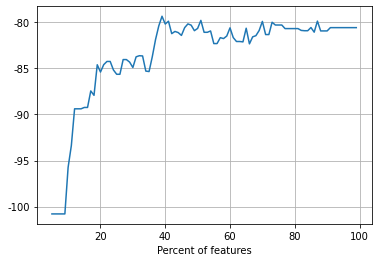

In [90]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X1, y1)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y1, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [91]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X1, y1)
X1_select = fs.transform(X1)
target1_select = fs.transform(target1)

print(X1_select.shape)
print(X1.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 43)
['요일', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '출장근무자_년평균', '휴가자_년평균', '야간근무자_일최대', '출장근무자_일최대', '야간근무자_주평균', '출장근무자_주평균', '출장근무자_주최대', '휴가자_주평균', '휴가자_주최대', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최소', '요일_중식계', '요일_석식계', '면 및 만두류', '국(탕)류', '찌개류', '전류', '볶음류', '김치류', '회류', '젓갈류', '음료류', '원재료', '조리_기타', '중식점수']


#### 셀렉션 진행 후 상관관계가 높은 변수를 제외하여 피쳐를 정함

In [92]:
X1 = train_점심[['요일', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '출장근무자_년평균', '휴가자_년평균', '야간근무자_일최대', '출장근무자_일최대', '야간근무자_주평균', '출장근무자_주평균', '출장근무자_주최대', '휴가자_주평균', '휴가자_주최대', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최소', '요일_중식계', '요일_석식계', '면 및 만두류', '국(탕)류', '찌개류', '전류', '볶음류', '김치류', '회류', '젓갈류', '음료류', '원재료', '조리_기타', '중식점수']]
y1 = train.중식계
target1 = test_점심[X1.columns]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [01:24<00:00,  1.12it/s]

(71, -56.66545518016203)


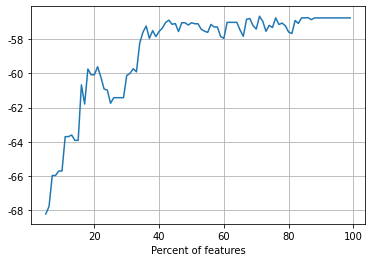

In [93]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X2, y2)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y2, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [94]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X2, y2)
X2_select = fs.transform(X2)
target2_select = fs.transform(target2)

print(X2_select.shape)
print(X2.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 79)
['요일', '년', '월', '주', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '야간근무자_년최대', '출장근무자_년평균', '출장근무자_년최대', '출장근무자_년최소', '휴가자_년평균', '휴가자_년최대', '휴가자_년최소', '재택근무자_월평균', '야간근무자_월평균', '야간근무자_월최대', '출장근무자_월최대', '휴가자_월평균', '휴가자_월최대', '휴가자_월최소', '재택근무자_일평균', '야간근무자_일평균', '야간근무자_일최대', '출장근무자_일최소', '휴가자_일최소', '재택근무자_주평균', '야간근무자_주평균', '야간근무자_주최대', '휴가자_주평균', '휴가자_주최대', '휴가자_주최소', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최대', '휴가자_요일최소', '재택근무자_계절평균', '재택근무자_계절최대', '야간근무자_계절평균', '야간근무자_계절최대', '출장근무자_계절평균', '출장근무자_계절최대', '출장근무자_계절최소', '휴가자_계절평균', '휴가자_계절최대', '휴가자_계절최소', '요일_중식계', '요일_석식계', '계절_중식계', '계절_석식계', '밥류', '국(탕)류', '찌개류', '찜류', '구이류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '장류', '우유 및 유제품류', '떡류', '원재료', '석식점수']


In [95]:
X2 = train_저녁[['요일', '년', '월', '주', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '야간근무자_년최대', '출장근무자_년평균', '출장근무자_년최대', '출장근무자_년최소', '휴가자_년평균', '휴가자_년최대', '휴가자_년최소', '재택근무자_월평균', '야간근무자_월평균', '야간근무자_월최대', '출장근무자_월최대', '휴가자_월평균', '휴가자_월최대', '휴가자_월최소', '재택근무자_일평균', '야간근무자_일평균', '야간근무자_일최대', '출장근무자_일최소', '휴가자_일최소', '재택근무자_주평균', '야간근무자_주평균', '야간근무자_주최대', '휴가자_주평균', '휴가자_주최대', '휴가자_주최소', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최대', '휴가자_요일최소', '재택근무자_계절평균', '재택근무자_계절최대', '야간근무자_계절평균', '야간근무자_계절최대', '출장근무자_계절평균', '출장근무자_계절최대', '출장근무자_계절최소', '휴가자_계절평균', '휴가자_계절최대', '휴가자_계절최소', '요일_중식계', '요일_석식계', '계절_중식계', '계절_석식계', '밥류', '국(탕)류', '찌개류', '찜류', '구이류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '장류', '우유 및 유제품류', '떡류', '원재료', '석식점수']]
y2 = train.석식계
target2 = test_저녁[X2.columns]

In [96]:
kf = KFold(n_splits = 15, random_state = 607, shuffle = True)

lgbm = LGBMRegressor(random_state = 607, max_depth = 4, n_estimators = 20000, learning_rate = .01)

lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 39.0524	training's l2: 2663.5	valid_1's l1: 62.2652	valid_1's l2: 6673.96
Early stopping, best iteration is:
[1539]	training's l1: 42.8359	training's l2: 3218.45	valid_1's l1: 61.5201	valid_1's l2: 6702.38
FOLD MAE = 61.52006182022204
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 37.426	training's l2: 2467.98	valid_1's l1: 59.2325	valid_1's l2: 5809.28
Early stopping, best iteration is:
[1503]	training's l1: 41.6575	training's l2: 3066.61	valid_1's l1: 58.9235	valid_1's l2: 5749.6
FOLD MAE = 58.92346366696711
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 38.3687	training's l2: 2586.53	valid_1's l1: 74.3732	valid_1's l2: 10136.7
Early stopping, best iteration is:
[1605]	training's l1: 40.901	training's l2: 2943.6	valid_1's l1: 74.5094	valid_1's l2: 10071.9
FOLD MAE = 74.50940711251782
Training until validation scores don't imp

In [97]:
lgbm_pred_2 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 24.1249	training's l2: 1113.51	valid_1's l1: 50.8954	valid_1's l2: 5019.18
Early stopping, best iteration is:
[1232]	training's l1: 28.8751	training's l2: 1595.2	valid_1's l1: 50.6795	valid_1's l2: 4898
FOLD MAE = 50.679493231575975
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 22.8621	training's l2: 912.924	valid_1's l1: 51.8244	valid_1's l2: 8097.56
Early stopping, best iteration is:
[1208]	training's l1: 28.1868	training's l2: 1406.83	valid_1's l1: 51.1363	valid_1's l2: 7961.77
FOLD MAE = 51.13626095817595
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 23.9261	training's l2: 1043.72	valid_1's l1: 50.5497	valid_1's l2: 5187.06
[4000]	training's l1: 18.2643	training's l2: 594.396	valid_1's l1: 49.5709	valid_1's l2: 5239.91
Early stopping, best iteration is:
[2787]	training's l1: 21.2154	training's l2: 806.142	valid_1's l1: 49

In [99]:
sub['중식계'] = lgbm_pred_1
sub['석식계'] = lgbm_pred_2

sub.to_csv('lgbm_08.csv', index = False)

In [100]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 61.91712188759171
FOLD MAE = 44.303112323491774
FOLD MAE = 33.190311047148484
FOLD MAE = 30.850593398388046
FOLD MAE = 26.646026571636114
FOLD MAE = 27.38376605965061
FOLD MAE = 25.246879253695326
FOLD MAE = 28.471729031357178
FOLD MAE = 23.2840539862871
FOLD MAE = 23.291399036428373
FOLD MAE = 26.233322840723822
FOLD MAE = 21.047706879414925
FOLD MAE = 21.039945123209048
FOLD MAE = 21.607567728679633
FOLD MAE = 18.556625364518045

NGBRegressor MAE = 28.871344035481346


In [101]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 49.38987790948225
FOLD MAE = 26.047134006267648
FOLD MAE = 23.08987984907987
FOLD MAE = 18.025295456372575
FOLD MAE = 20.574132137364202
FOLD MAE = 15.782133997830886
FOLD MAE = 17.360119658901173
FOLD MAE = 14.55535028052221
FOLD MAE = 16.628500720192783
FOLD MAE = 14.815169452405673
FOLD MAE = 12.378371844213797
FOLD MAE = 12.66994999455343
FOLD MAE = 13.411980377074281
FOLD MAE = 14.652960751817016
FOLD MAE = 10.980362983526803

NGBRegressor MAE = 18.690747961306975


In [103]:
sub['중식계'] = ngb_pred_1
sub['석식계'] = ngb_pred_2

sub.to_csv('nbg_08.csv', index = False)

nbg=pd.read_csv('nbg_08.csv')
lgbm=pd.read_csv('lgbm_08.csv')

ensemble=nbg.copy()
ensemble['중식계']=nbg['중식계']*0.5+lgbm['중식계']*0.5
ensemble['석식계']=nbg['석식계']*0.5+lgbm['석식계']*0.5

ensemble.to_csv('ensemble_08.csv', index = False)

### 앙상블

In [ ]:
ensemble_1=pd.read_csv('ensemble_08.csv') #63.5
ensemble_2=pd.read_csv('ensemble_07.csv') #62
ensemble_3=pd.read_csv('sub1.csv') #66
ensemble_all=ensemble_1.copy()

ensemble_all['중식계']=ensemble_1['중식계']*0.6 + ensemble_2['중식계']*0.3 + ensemble_3['중식계']*0.1
ensemble_all['석식계']=ensemble_1['석식계']*0.6 + ensemble_2['석식계']*0.3 + ensemble_3['석식계']*0.1
ensemble_all.to_csv('ensemble_new.csv', index = False)